## The project: **Predict whether a patient has breast cancer** based on diagnostic measurements and to **explain how the model made each decision**

This project demonstrates how **Explainable AI (XAI)** techniques can make a machine learning model’s reasoning transparent and trustworthy — especially in a medical context where understanding *why* a prediction was made is just as important as *what* the prediction is.

---

### Goal

To develop a predictive model that determines whether a breast tumor is **malignant (cancerous)** or **benign (non-cancerous)** using features derived from the **Breast Cancer Wisconsin Diagnostic dataset**.  
The project goes beyond accuracy — it focuses on **explainability**, showing the reasoning behind each individual prediction.

---

### Methodology

1. **Model Training:**  
   An **XGBoost classifier** was trained on 30 features describing the geometry, texture, and irregularity of cell nuclei (e.g., perimeter, area, smoothness, concavity).

2. **Evaluation:**  
   The model achieved a high **F1-score**, indicating strong balance between precision and recall.  

3. **Explainability (SHAP):**  
   The **SHAP (SHapley Additive exPlanations)** framework was used to interpret both:
   - **Global explanations** — which features are most influential overall.  
   - **Local explanations** — why a specific patient was classified as cancerous or not.

---

### How Explainability Works

- SHAP assigns each feature a **contribution value (SHAP value)** for every prediction.  
- Positive SHAP values push the model toward *benign*, while negative ones push toward *malignant*.  
- By examining SHAP values, we can see **which clinical features drove each decision** and in which direction.

For example:
- A **high “worst perimeter”** or **“worst area”** decreases the model’s confidence in benign classification — typical for malignant tumors.  
- A **low “concavity” or “texture”** increases confidence in a benign diagnosis.

---

### Visual Insights

- The **global SHAP bar chart** highlights that features such as  
  `worst perimeter`, `worst texture`, `worst concave points`, and `worst area`  
  are the strongest indicators of malignancy.
- The **per-patient SHAP analyses** show that different patients are influenced by different dominant features, allowing **case-by-case transparency**.

---

### Why Explainability Matters

In healthcare, predictive models must be:
- **Accurate** — to assist diagnosis effectively.  
- **Transparent** — so clinicians can verify and trust the reasoning.  
- **Accountable** — by showing which measurements led to each prediction.

Using SHAP makes the model **interpretable, auditable, and medically meaningful**, bridging the gap between AI predictions and human clinical reasoning.

---

### Summary

| Aspect | Description |
|---------|--------------|
| **Dataset** | Breast Cancer Wisconsin (Diagnostic) |
| **Model** | XGBoost Classifier |
| **Explainability Method** | SHAP (SHapley Additive Explanations) |
| **Outputs** | Prediction (Malignant / Benign) + Feature-level reasoning |
| **Impact** | Provides interpretable, trustworthy AI decisions for medical analysis |

In essence, this project combines **machine learning performance** with **human-level interpretability**, showing not only what the model predicts — but *why it thinks so*.


## The dataset: Breast Cancer Wisconsin (Diagnostic)

The **Breast Cancer Wisconsin (Diagnostic)** dataset is a well-known built-in dataset from `scikit-learn` used for binary classification.  
It contains measurements computed from digitized images of fine needle aspirate (FNA) of breast masses.

Each sample represents a **breast tissue biopsy**, and the goal is to predict whether the tumor is **malignant** (cancerous) or **benign** (non-cancerous).

---

### Dataset Structure

- **Number of samples:** 569  
- **Number of features (columns):** 30 numeric features  
- **Target classes:** 2  
  - `0` → *malignant*  
  - `1` → *benign*

---

### Feature Groups

Each of the 30 columns describes a property of the cell nuclei found in the image.  
They are derived from ten real-valued measurements, each with **mean**, **standard error**, and **worst (largest)** values.

| Feature Group | Example Columns | Description |
|----------------|----------------|--------------|
| **Radius** | `mean radius`, `radius error`, `worst radius` | Mean distance from center to perimeter of nucleus |
| **Texture** | `mean texture`, `texture error`, `worst texture` | Standard deviation of gray-scale values |
| **Perimeter** | `mean perimeter`, `perimeter error`, `worst perimeter` | Boundary length of the nucleus |
| **Area** | `mean area`, `area error`, `worst area` | Area size of the nucleus |
| **Smoothness** | `mean smoothness`, `smoothness error`, `worst smoothness` | Local variation in radius lengths |
| **Compactness** | `mean compactness`, `compactness error`, `worst compactness` | (Perimeter² / Area) - 1.0 |
| **Concavity** | `mean concavity`, `concavity error`, `worst concavity` | Severity of concave portions of the contour |
| **Concave Points** | `mean concave points`, `concave points error`, `worst concave points` | Number of concave portions of the contour |
| **Symmetry** | `mean symmetry`, `symmetry error`, `worst symmetry` | Symmetry of the cell nuclei |
| **Fractal Dimension** | `mean fractal dimension`, `fractal dimension error`, `worst fractal dimension` | "Coastline approximation"—complexity of contour shape |

---

### Target (Label) Column

- The **target column** is `target` or sometimes referred to as `diagnosis`.  
- It encodes whether the tumor is:
  - **0 → malignant (cancerous)**
  - **1 → benign (non-cancerous)**

---

### Summary

| Property | Value |
|-----------|--------|
| Samples | 569 |
| Features | 30 numeric features |
| Classes | Malignant (0), Benign (1) |
| Task | Binary classification |
| Common Uses | Model interpretability, SHAP explainability, feature importance visualization |

Dataset shape: (569, 30)
Target distribution:
 target
1    357
0    212
Name: count, dtype: int64
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        53
           1       0.97      0.99      0.98        90

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

F1 Score: 0.978


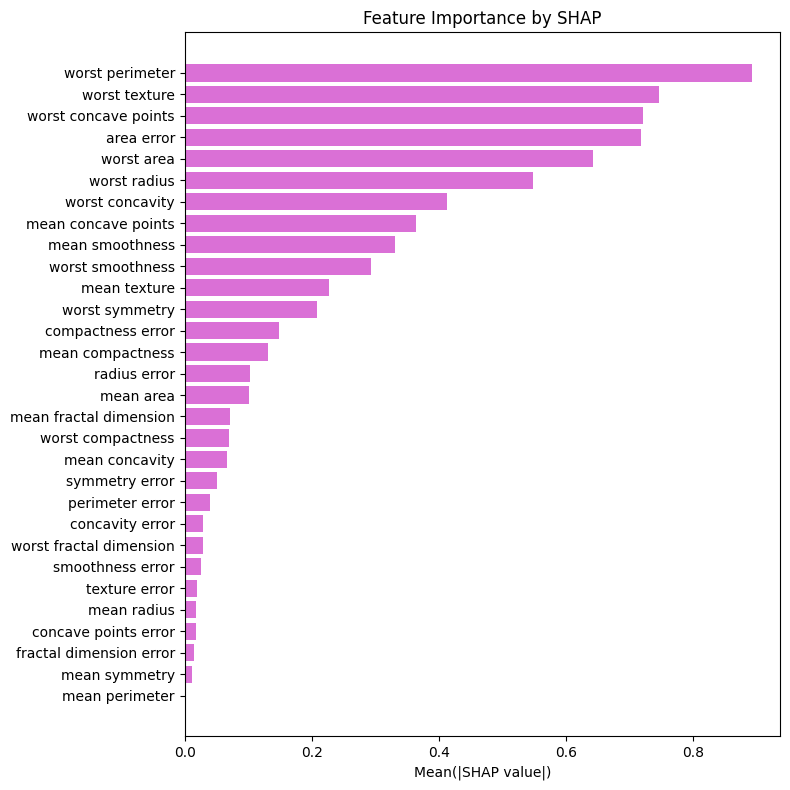

In [10]:
# ===============================
# Explainable AI: Breast Cancer (SHAP)
# ===============================

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# === Load Dataset ===
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("Dataset shape:", X.shape)
print("Target distribution:\n", y.value_counts())

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# === Model Training with GridSearch for F1 optimization ===
params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
grid = GridSearchCV(model, params, scoring='f1', cv=5, verbose=0, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# === Evaluation ===
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))

# === SHAP Analysis ===
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# === SHAP Feature Importance Bar Chart ===
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean|SHAP|": mean_abs_shap
}).sort_values("Mean|SHAP|", ascending=True)

plt.figure(figsize=(8, 8))
plt.barh(importance_df["Feature"], importance_df["Mean|SHAP|"], color="orchid")
plt.xlabel("Mean(|SHAP value|)")
plt.title("Feature Importance by SHAP")
plt.tight_layout()
plt.show()

# === Example: Top-5 features for a single patient ===
n = 0  # choose a test sample index
single_sample = X_test.iloc[[n]]
single_shap = shap_values[n]

vals = single_shap.values
feats = X_test.columns.to_numpy()
top_idx = np.argsort(np.abs(vals))[::-1][:5]
top_feats = feats[top_idx]
top_vals = vals[top_idx]

df_top = pd.DataFrame({
    "Feature": top_feats,
    "Value": single_sample[top_feats].iloc[0].to_numpy(),
    "SHAP": top_vals,
    "Abs_SHAP": np.abs(top_vals)
}).sort_values("Abs_SHAP", ascending=False).reset_index(drop=True)



## Explanation of the Graph: Feature Importance by SHAP

The graph shows the **ranking of features** that most strongly influence the model’s predictions for **breast cancer diagnosis** (malignant vs. benign).  
Each bar represents the **average absolute SHAP value** of a feature — meaning how much, on average, that feature contributes to the model’s decision, regardless of direction.

---

### Most Influential Features

The top features in the graph —  
**`worst perimeter`**, **`worst texture`**, **`worst concave points`**, **`area error`**, and **`worst area`** —  
have the **highest mean SHAP values**, meaning they play the largest role in determining whether a sample is classified as *cancerous* or *non-cancerous*.

- **`worst perimeter` and `worst area`**  
  → Tumors with a large perimeter or area tend to be malignant.  
  These features describe the *size* of the cell clusters.  
  A bigger, irregular boundary increases cancer likelihood.

- **`worst texture` and `worst concave points`**  
  → Capture irregularities and roughness in the cell structure.  
  Malignant cells usually have less uniform texture and more concave shapes.

- **`area error`**  
  → Reflects variation in cell area measurements.  
  Larger inconsistencies often indicate abnormal (cancerous) growth.

---

### Interpretation Summary

| Observation | Meaning |
|--------------|----------|
| **Top features (worst perimeter, texture, concave points)** | Indicate that extreme shape and size measurements are key markers for malignancy. |
| **Middle features (smoothness, compactness)** | Provide secondary clues about tissue regularity. |
| **Low features (symmetry, fractal dimension)** | Have little influence on the decision and may be redundant for prediction. |



================ EXAMPLES: SHAP Top-5 per Sample ================

------------------------------------------------------------
Example #1 — Predicted: Malignant (Cancer) | True: Malignant
             Feature     Value      SHAP
     worst perimeter  138.1000 -1.306823
worst concave points    0.1974 -1.160639
          area error   49.8100 -1.153125
          worst area 1349.0000 -0.933954
        worst radius   21.0800 -0.932736


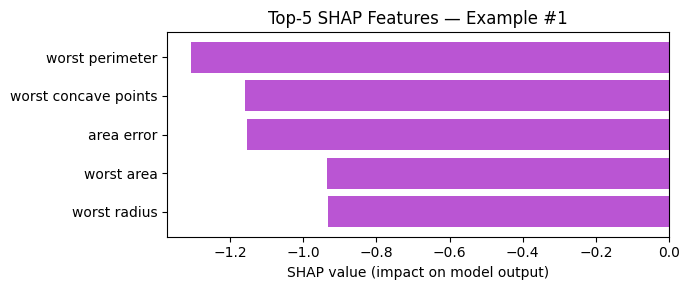

------------------------------------------------------------
Example #2 — Predicted: Malignant (Cancer) | True: Malignant
             Feature     Value      SHAP
     worst perimeter  160.2000 -1.095150
worst concave points    0.2148 -1.090037
          area error   87.7800 -1.076369
        worst radius   24.3000 -0.910351
          worst area 1809.0000 -0.870532


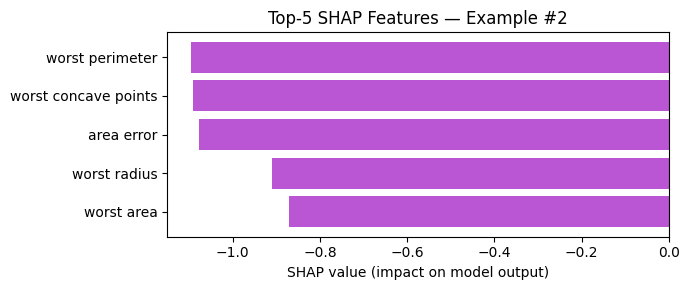

------------------------------------------------------------
Example #3 — Predicted: Malignant (Cancer) | True: Malignant
             Feature    Value      SHAP
worst concave points   0.2060 -2.060950
       worst texture  30.7300 -1.396582
    worst smoothness   0.1703 -0.694800
     worst perimeter 106.2000 -0.648462
     worst concavity   0.5390 -0.489989


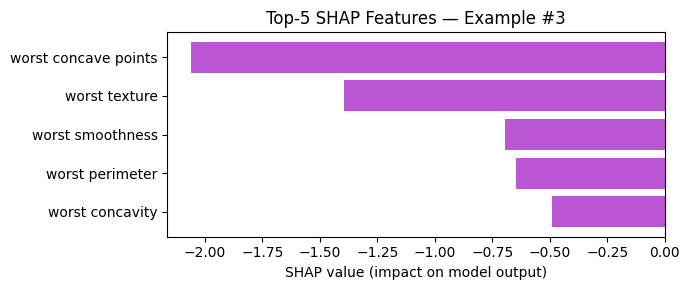

------------------------------------------------------------
Example #4 — Predicted: Malignant (Cancer) | True: Malignant
         Feature     Value      SHAP
 worst perimeter  148.2000 -1.161308
      area error   81.2300 -1.009959
worst smoothness    0.1021  0.974837
      worst area 1538.0000 -0.974416
    worst radius   22.3200 -0.831928


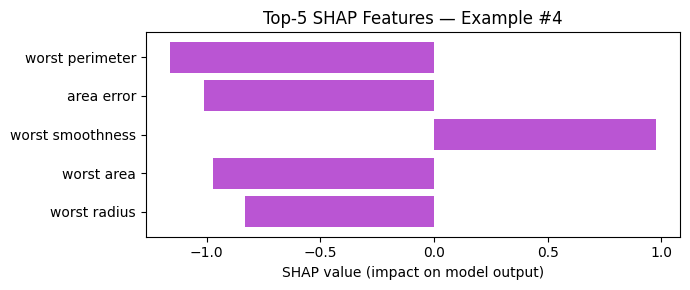

------------------------------------------------------------
Example #5 — Predicted: Malignant (Cancer) | True: Malignant
             Feature     Value      SHAP
     worst perimeter  152.1000 -1.327596
worst concave points    0.1966 -1.252617
        worst radius   22.6900 -0.970086
          worst area 1535.0000 -0.877817
          area error   39.0600 -0.687808


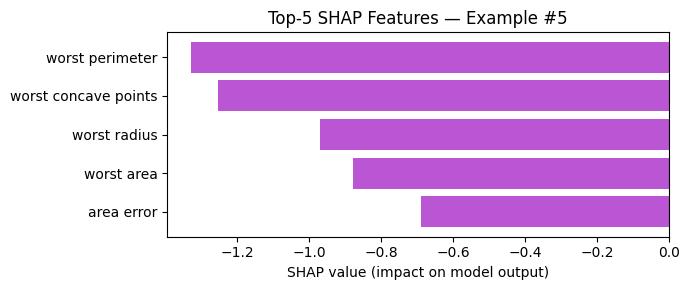

------------------------------------------------------------
Example #6 — Predicted: Benign (No Cancer) | True: Benign
             Feature     Value     SHAP
       worst texture  21.74000 0.813256
worst concave points   0.08045 0.799031
          worst area 624.10000 0.673581
     worst concavity   0.14230 0.550407
          area error  28.62000 0.527175


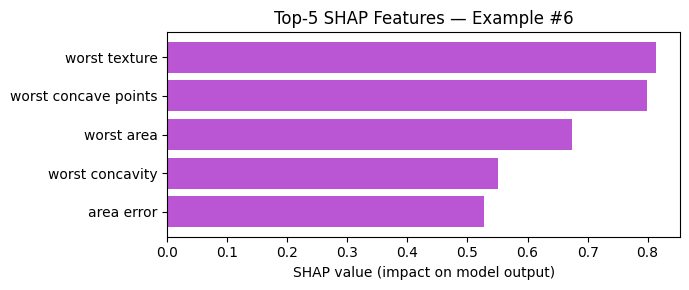

------------------------------------------------------------
Example #7 — Predicted: Benign (No Cancer) | True: Benign
             Feature     Value      SHAP
worst concave points   0.14890 -1.488409
       worst texture  26.19000 -0.756084
     mean smoothness   0.08992  0.745523
     worst perimeter 109.10000 -0.616189
     worst concavity   0.18040  0.527456


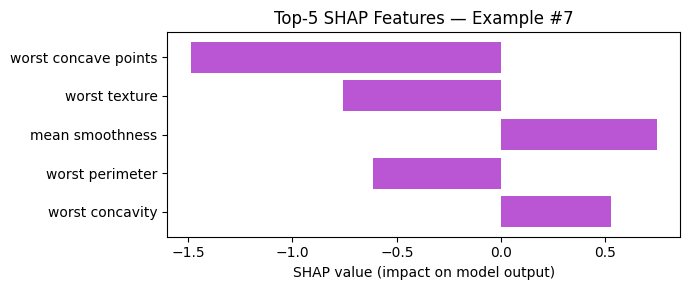

------------------------------------------------------------
Example #8 — Predicted: Benign (No Cancer) | True: Benign
             Feature   Value      SHAP
     worst concavity  0.1246  0.591821
     worst perimeter 99.3100  0.581861
worst concave points  0.1096  0.578087
          area error 34.3700 -0.444632
     mean smoothness  0.1218 -0.417832


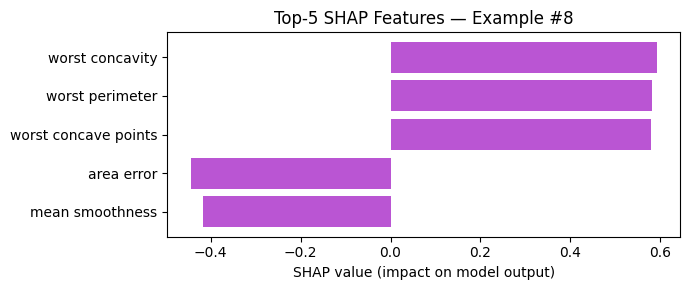

------------------------------------------------------------
Example #9 — Predicted: Benign (No Cancer) | True: Malignant
        Feature     Value      SHAP
  worst texture  31.71000 -1.060784
worst perimeter 102.20000  0.709210
mean smoothness   0.08682  0.687196
   worst radius  15.79000  0.494390
   mean texture  23.29000 -0.423237


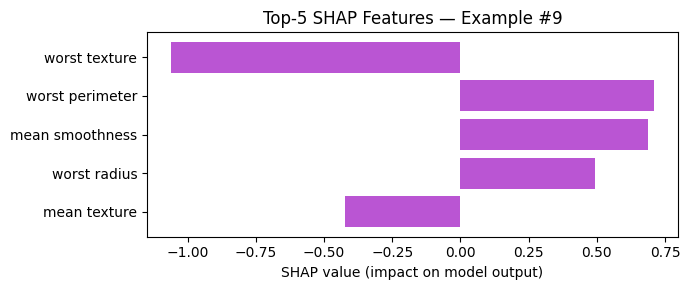

------------------------------------------------------------
Example #10 — Predicted: Benign (No Cancer) | True: Benign
             Feature     Value     SHAP
     worst perimeter  80.79000 0.798505
          area error  12.98000 0.715462
       worst texture  20.35000 0.696728
worst concave points   0.05556 0.673746
          worst area 496.70000 0.635794


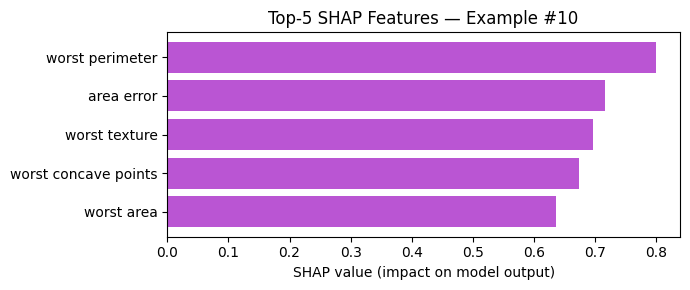

In [11]:
# === Show Top-5 SHAP Features for 10 Patients (5 Malignant / 5 Benign) ===

# Predictions
y_pred = best_model.predict(X_test)

# Select examples: 5 predicted malignant (1) and 5 benign (0)
malignant_idx = np.where(y_pred == 0)[0][:5]  # class 0 = malignant
benign_idx = np.where(y_pred == 1)[0][:5]     # class 1 = benign
selected_idx = np.concatenate([malignant_idx, benign_idx])

print("\n================ EXAMPLES: SHAP Top-5 per Sample ================\n")

for i, n in enumerate(selected_idx):
    single_sample = X_test.iloc[[n]]
    single_shap = shap_values[n]
    vals = single_shap.values
    feats = X_test.columns.to_numpy()
    top_idx = np.argsort(np.abs(vals))[::-1][:5]
    top_feats = feats[top_idx]
    top_vals = vals[top_idx]

    df_top = pd.DataFrame({
        "Feature": top_feats,
        "Value": single_sample[top_feats].iloc[0].to_numpy(),
        "SHAP": top_vals,
        "Abs_SHAP": np.abs(top_vals)
    }).sort_values("Abs_SHAP", ascending=False).reset_index(drop=True)

    pred_label = "Benign (No Cancer)" if y_pred[n] == 1 else "Malignant (Cancer)"
    true_label = "Benign" if y_test.iloc[n] == 1 else "Malignant"

    print("------------------------------------------------------------")
    print(f"Example #{i+1} — Predicted: {pred_label} | True: {true_label}")
    print(df_top[["Feature", "Value", "SHAP"]].to_string(index=False))

    # Plot barh for top 5
    plt.figure(figsize=(7, 3))
    order = np.arange(len(df_top))[::-1]
    plt.barh(df_top["Feature"].iloc[order], df_top["SHAP"].iloc[order], color="mediumorchid")
    plt.xlabel("SHAP value (impact on model output)")
    plt.title(f"Top-5 SHAP Features — Example #{i+1}")
    plt.tight_layout()
    plt.show()


## Top-5 SHAP Features — Malignant (Cancer) Predictions

| Example | Feature | Value | SHAP |
|----------|----------|--------|--------|
| **#1** | worst perimeter | 138.10 | -1.3068 |
|  | worst concave points | 0.1974 | -1.1606 |
|  | area error | 49.81 | -1.1531 |
|  | worst area | 1349.00 | -0.9339 |
|  | worst radius | 21.08 | -0.9327 |
| **#2** | worst perimeter | 160.20 | -1.0952 |
|  | worst concave points | 0.2148 | -1.0900 |
|  | area error | 87.78 | -1.0764 |
|  | worst radius | 24.30 | -0.9104 |
|  | worst area | 1809.00 | -0.8705 |
| **#3** | worst concave points | 0.2060 | -2.0610 |
|  | worst texture | 30.73 | -1.3966 |
|  | worst smoothness | 0.1703 | -0.6948 |
|  | worst perimeter | 106.20 | -0.6485 |
|  | worst concavity | 0.5390 | -0.4900 |
| **#4** | worst perimeter | 148.20 | -1.1613 |
|  | area error | 81.23 | -1.0100 |
|  | worst smoothness | 0.1021 | 0.9748 |
|  | worst area | 1538.00 | -0.9744 |
|  | worst radius | 22.32 | -0.8319 |
| **#5** | worst perimeter | 152.10 | -1.3276 |
|  | worst concave points | 0.1966 | -1.2526 |
|  | worst radius | 22.69 | -0.9701 |
|  | worst area | 1535.00 | -0.8778 |
|  | area error | 39.06 | -0.6878 |

---

## Top-5 SHAP Features — Benign (No Cancer) Predictions

| Example | Feature | Value | SHAP |
|----------|----------|--------|--------|
| **#6** | worst texture | 21.74 | 0.8133 |
|  | worst concave points | 0.08045 | 0.7990 |
|  | worst area | 624.10 | 0.6736 |
|  | worst concavity | 0.1423 | 0.5504 |
|  | area error | 28.62 | 0.5272 |
| **#7** | worst concave points | 0.1489 | -1.4884 |
|  | worst texture | 26.19 | -0.7561 |
|  | mean smoothness | 0.0899 | 0.7455 |
|  | worst perimeter | 109.10 | -0.6162 |
|  | worst concavity | 0.1804 | 0.5275 |
| **#8** | worst concavity | 0.1246 | 0.5918 |
|  | worst perimeter | 99.31 | 0.5819 |
|  | worst concave points | 0.1096 | 0.5781 |
|  | area error | 34.37 | -0.4446 |
|  | mean smoothness | 0.1218 | -0.4178 |
| **#9** | worst texture | 31.71 | -1.0608 |
|  | worst perimeter | 102.20 | 0.7092 |
|  | mean smoothness | 0.0868 | 0.6872 |
|  | worst radius | 15.79 | 0.4944 |
|  | mean texture | 23.29 | -0.4232 |
| **#10** | worst perimeter | 80.79 | 0.7985 |
|  | area error | 12.98 | 0.7155 |
|  | worst texture | 20.35 | 0.6967 |
|  | worst concave points | 0.0556 | 0.6737 |
|  | worst area | 496.70 | 0.6358 |

---

### Interpretation Summary

- For **malignant** cases, the most influential features have **negative SHAP values**,  
  meaning high values of those features push the model toward *cancer* predictions.  
  Key drivers: `worst perimeter`, `worst area`, and `worst concave points`.

- For **benign** cases, features tend to have **positive SHAP values**,  
  pushing the prediction toward *no cancer*.  
  Common indicators: lower `concavity`, smoother texture, and smaller area.

These two tables illustrate how SHAP reveals **feature-level reasoning** per individual prediction —  
showing not just what the model decided, but *why* it made that decision.
